In [1]:
%load_ext autoreload
%autoreload 2


# Load relevent data


In [2]:
from nba import NbaTracker
from nba_api.stats.static.players import find_player_by_id
from nba_api.stats.static.teams import find_team_name_by_id
from build_simple_rebound_model import build_simple_rebound_model

nbaTracker = NbaTracker()
season_name = "2015-16"
nbaTracker.add_season(season_name)
season = nbaTracker.seasons[season_name]
season.load_possession_data()
preprocess, rebound_model = build_simple_rebound_model(season)
# season.build_player_seasons()
games = season.games


In [3]:
from sklearn.model_selection import train_test_split
train_game_ids, test_game_ids = train_test_split(list(games.keys()), test_size=0.1, random_state=432536)
len(train_game_ids), len(test_game_ids)


(1107, 123)

In [22]:
from PlayerTracker import PlayerTracker
players = PlayerTracker(season)
players.add_games(train_game_ids)


# Add rebound pbp data to players

In [5]:
from build_simple_rebound_model import get_rebound_df_from_games

train_games = [games[game_id] for game_id in train_game_ids]
train_df = get_rebound_df_from_games(train_games)
processed_train_X = preprocess.transform(train_df)
predictions = rebound_model.predict(processed_train_X)[0]

In [47]:
train_y = train_df[['result_class']].to_numpy() - 1

In [ ]:
rebound_index = 0
from nba_dataclasses import EventType
for game in train_games:
    for ge in game.game_events:
        if ge.event_type == EventType.Rebound:
            chances = [0, *predictions[rebound_index]]
            rebound_index += 1
            if rebound_index % 10000 == 0:
                print("evaled", rebound_index)
            players.add_rebound_event(ge, chances)

# Go through train games to generate rebounds with player data

In [42]:
import numpy as np

rebound_index = 0
off_players_rebounds = []
def_players_rebounds = []
for game in train_games:
    players.undo_add_game(game.game_id)
    for ge in game.game_events:
        if ge.event_type == EventType.Rebound:
            chances = [0, *predictions[rebound_index]]
            rebound_index += 1
            if rebound_index % 10000 == 0:
                print("evaled", rebound_index)
                
            players.undo_add_rebound_event(ge, chances)

            # get player data
            lineup = ge.lineup.lineup
            off_players = []
            for player_id in lineup[0]:
                off_players.append(players[player_id].get_stats())
            off_players_rebounds.append(off_players)
            def_players = []
            for player_id in lineup[1]:
                def_players.append(players[player_id].get_stats())
            def_players_rebounds.append(def_players)

            players.add_rebound_event(ge, chances)
    players.redo_add_game(game.game_id)

off_players_rebounds = np.array(off_players_rebounds)
def_players_rebounds = np.array(def_players_rebounds)


In [45]:
def_players_rebounds.shape


(108878, 5, 68)

In [64]:
import tensorflow as tf
shot_ds = tf.data.Dataset.from_tensor_slices(processed_train_X)
off_ds = tf.data.Dataset.from_tensor_slices(off_players_rebounds)
def_ds = tf.data.Dataset.from_tensor_slices(def_players_rebounds)
y_ds = tf.data.Dataset.from_tensor_slices(train_y)
train_ds = tf.data.Dataset.zip(
    (tf.data.Dataset.zip((shot_ds, off_ds, def_ds)), 
    y_ds))
train_ds = train_ds.shuffle(1000).batch(32).prefetch(1)


# Build model to use player data

In [60]:
import tensorflow as tf 

shot_input = tf.keras.Input(processed_train_X.shape[1:])
off_players_input = tf.keras.Input(off_players_rebounds.shape[1:])
def_players_input = tf.keras.Input(def_players_rebounds.shape[1:])

off_conv1 = tf.keras.layers.Conv1D(
    64, 1, activation='relu')(off_players_input)
off_conv2 = tf.keras.layers.Conv1D(
    64, 1, activation='relu')(off_conv1)
# off_conv3 = tf.keras.layers.Conv1D(32, 1, activation='relu')(off_conv2)
off_conv3 = tf.keras.layers.Conv1D(8, 1, activation='relu')(off_conv2)
off_pool = tf.keras.layers.GlobalAveragePooling1D()(off_conv3)

def_conv1 = tf.keras.layers.Conv1D(
    64, 1, activation='relu')(def_players_input)
def_conv2 = tf.keras.layers.Conv1D(
    64, 1, activation='relu')(def_conv1)
def_conv3 = tf.keras.layers.Conv1D(8, 1, activation='relu')(def_conv2)
# def_conv4 = tf.keras.layers.Conv1D(8, 1, activation='relu')(def_conv3)
def_pool = tf.keras.layers.GlobalAveragePooling1D()(def_conv3)

concat = tf.keras.layers.concatenate([shot_input, off_pool, def_pool])
dense1 = tf.keras.layers.Dense(32, activation='relu')(concat)
dense2 = tf.keras.layers.Dense(32, activation='relu')(dense1)
output = tf.keras.layers.Dense(10, activation='softmax')(dense2)

player_rebound_model = tf.keras.Model(inputs=[shot_input, off_players_input, def_players_input], outputs=output)




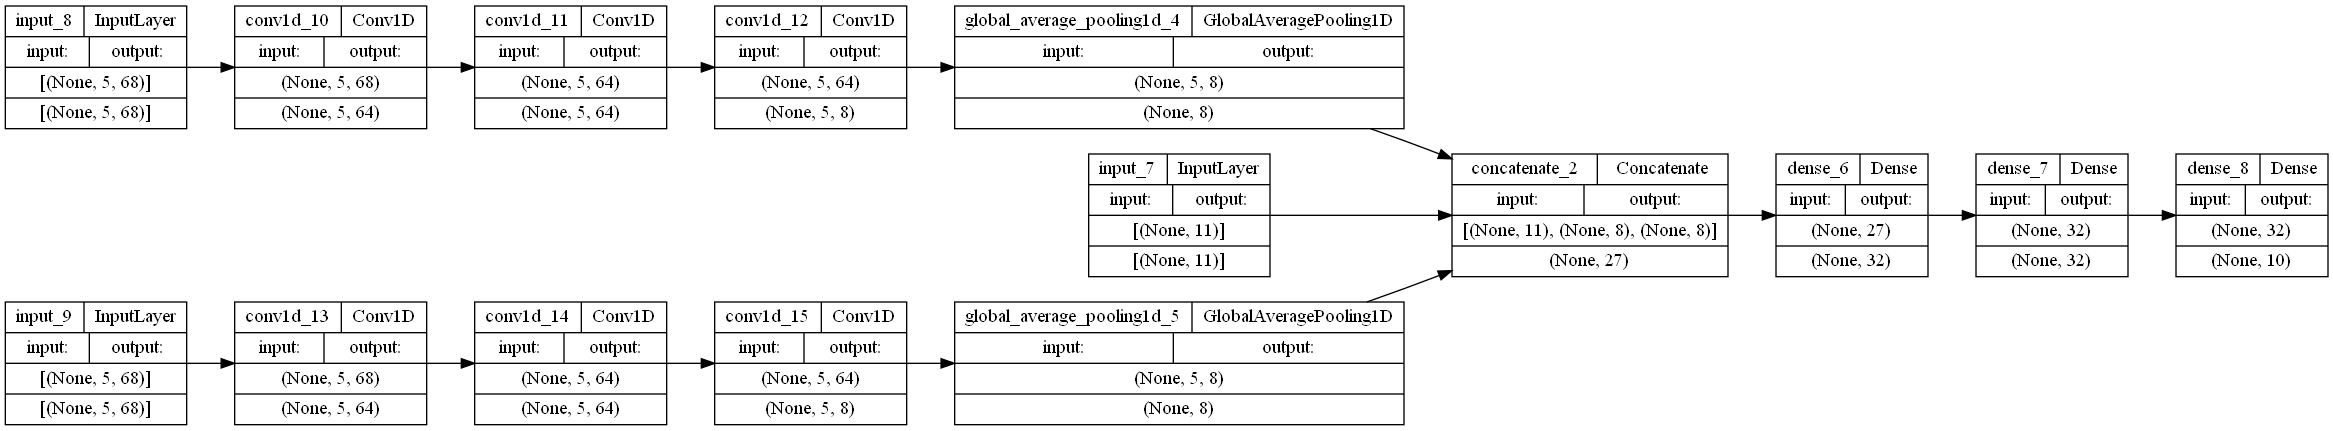

In [66]:
tf.keras.utils.plot_model(player_rebound_model, rankdir='LR', show_shapes=True)


In [61]:
player_rebound_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [62]:
player_rebound_model.fit(
    [processed_train_X, off_players_rebounds, def_players_rebounds], train_y, epochs=1)


3403/3403 [==============================] - 90s 26ms/step - loss: 1.0138 - accuracy: 0.6713


In [65]:
player_rebound_model.fit(train_ds, epochs=10)


Epoch 1/10
3403/3403 [==============================] - 84s 24ms/step - loss: 0.9353 - accuracy: 0.6757
Epoch 2/10
3403/3403 [==============================] - 83s 24ms/step - loss: 0.9257 - accuracy: 0.6760
Epoch 3/10
3403/3403 [==============================] - 80s 24ms/step - loss: 0.9205 - accuracy: 0.6760
Epoch 4/10
3403/3403 [==============================] - 79s 23ms/step - loss: 0.9180 - accuracy: 0.6760
Epoch 5/10
3403/3403 [==============================] - 81s 24ms/step - loss: 0.9163 - accuracy: 0.6759
Epoch 6/10
3403/3403 [==============================] - 82s 24ms/step - loss: 0.9156 - accuracy: 0.6760
Epoch 7/10
3403/3403 [==============================] - 93s 27ms/step - loss: 0.9152 - accuracy: 0.6760
Epoch 8/10
3403/3403 [==============================] - 78s 23ms/step - loss: 0.9148 - accuracy: 0.6760
Epoch 9/10
3403/3403 [==============================] - 81s 24ms/step - loss: 0.9146 - accuracy: 0.6760
Epoch 10/10
3403/3403 [==============================] - 80s 24m

In [25]:
rebound_stats = {}
for pid in players.players:
    rebound_stats[pid] = players.get_rebound_stats(pid)


In [36]:

count = 0
max_count = 20
for pid, stats in sorted(rebound_stats.items(), key=lambda item: item[1][0]+item[1][1]-item[1][2]-item[1][3], reverse=True):
    if players.players[pid].dreb_events < 100:
        continue
    print(find_player_by_id(pid)['full_name'], stats[0]+stats[1], stats[2]+stats[3])
    count += 1
    if count == max_count:
        break


Tony Wroten 0.2865731756361289 -0.23899036164545467
Briante Weber 0.06520453512734982 -0.2694149754685345
Elton Brand 0.09218291245727836 -0.1828708523932099
C.J. Wilcox 0.16517857456239526 -0.08291943116545439
Lamar Patterson 0.14047977634059028 -0.10001732179726897
Jeff Ayres 0.22325448148768756 -0.010856011093925647
Tiago Splitter 0.12243304467244254 -0.10146932485120705
Greg Smith 0.060635270203830936 -0.1432936349157593
Michael Kidd-Gilchrist 0.34661010200483655 0.16897888747815754
Damjan Rudez 0.02274277030227139 -0.14954999829488658
Chris Copeland 0.010375592902217796 -0.14406884304329196
Mike Muscala 0.10825308455228956 -0.04260424366988645
Carl Landry 0.07681166855096438 -0.06736965848527021
Salah Mejri 0.15403332892508673 0.01520733331191993
Richaun Holmes 0.08650089070856558 -0.05198375414398608
Christian Wood 0.11032471759198129 -0.0015327353065695132
Phil Pressey 0.0557997246616078 -0.05593522085067874
Jeremy Evans 0.06853853977746924 -0.037558463848745866
Tarik Black 0.06

In [37]:
rebound_stats[203100]


[0.2774651445688119,
 0.00910803106731702,
 -0.1658245068883042,
 -0.07316585475715047]

In [38]:
rebound_stats[203100]


[0.2774651445688119,
 0.00910803106731702,
 -0.1658245068883042,
 -0.07316585475715047]

In [39]:
players.players[203100]


PlayerSeasonData(player_id=203100, height=78, weight=205, age=23, exp=3, position=1, games=8, games_started=3, secs=8658, fg2m=19, fg2a=48, fg3m=3, fg3a=17, ftm=20, fta=37, oreb=2, dreb=19, ast=20, stl=3, blk=0, to=29, pf=11, plus_minus=-68.0, pt_games=11, pt_secs=8658, spd=3885998, dist=1073, orbc=16, drbc=33, tchs=402, sast=0, ftast=4, passes=284, pt_ast=20, cfgm=14, cfga=42, ufgm=8, ufga=23, dfgm=3, dfga=3, oreb_events=161, oreb_player_foul=0, oreb_player_fdraw=0, oreb_player_live_oreb=2, oreb_team_foul=0, oreb_team_fdraw=0, oreb_team_jumpballs=3, oreb_team_live_oreb=31, oreb_team_dead_oreb=10, oreb_team_foul_dif=-0.6166181524749845, oreb_team_fdraw_dif=-0.6038167163496837, oreb_team_jumpballs_dif=2.5168876624666154, oreb_team_live_oreb_dif=-2.5344725102186203, oreb_team_dead_oreb_dif=-0.884109865874052, dreb_events=146, dreb_player_foul=0, dreb_player_fdraw=0, dreb_player_live_dreb=19, dreb_team_foul=0, dreb_team_fdraw=0, dreb_team_jumpballs=0, dreb_team_live_oreb=32, dreb_team_dea

In [11]:
for i in sorted(rebound_stats.items():
    break

In [12]:
i

(201952,
 [0.0032627956155011476,
  -0.011886614860079268,
  0.02085725358277581,
  -0.016085475198889757])

In [14]:
k = 203515
len(players.rebound_opponents)

450

In [5]:
from nba_dataclasses import EventType, ResultClass 
import pandas as pd 


columns = ['result_class', 'result_team', 'num_fts', 'shot_type',
           'is_blocked', 'is_putback', 'in_penalty', 'offense_is_home', 'score_margin']
non_player_columns = columns[:]
num_rebound_inputs = 6

catagorical_attributes = ['shot_type']
binary_attributes = ['is_blocked', 'is_putback',
                      'in_penalty', 'offense_is_home']
numerical_attributes = ['score_margin']

player_id_indices = []
off_player_id_indices = []
def_player_id_indices = []
player_foul_indices = []

for team in ['off', 'def']:
    for player_num in [0, 1, 2, 3, 4]:
        player = 'player' + team + str(player_num)
        player_id_indices.append(player)
        columns.append(player)
team = 'off'
for player_num in [0, 1, 2, 3, 4]:
    player = 'player' + team + str(player_num)
    off_player_id_indices.append(player)
team = 'def'
for player_num in [0, 1, 2, 3, 4]:
    player = 'player' + team + str(player_num)
    def_player_id_indices.append(player)
for team in ['off', 'def']:
    for player_num in [0, 1, 2, 3, 4]:
        fouls = 'player' + team + str(player_num) + 'fouls'
        player_foul_indices.append(fouls)
        columns.append(fouls)

def get_rebound_df_from_game_ids(game_ids):
    rebounds = []
    for game_id in game_ids:
        game = games[game_id]
        last_game_event = None
        for ge in game.game_events:
            if ge.event_type == EventType.Rebound:
                result_class = ge.result.result_class
                # if result_class == ResultClass.JUMPBALL:
                #     result_team = 2
                if result_class in {
                        ResultClass.OFF_REBOUND, ResultClass.FT, ResultClass.SAME_TEAM}:
                    result_team = 1
                else:
                    result_team = 0
                num_fts = ge.result.num_fts
                shot_type = ge.result.shot_type
                is_blocked = ge.result.is_blocked
                is_putback = last_game_event.is_putback
                in_penalty = ge.in_penalty
                offense_is_home = ge.offense_is_home
                score_margin = ge.score_margin

                rebound = [
                    result_class,
                    result_team,
                    num_fts,
                    shot_type,
                    is_blocked,
                    is_putback,
                    in_penalty,
                    offense_is_home,
                    score_margin,
                ]

                for team in [0, 1]:
                    for player_num in [0, 1, 2, 3, 4]:
                        player_id = ge.lineup.lineup[team][player_num]
                        rebound.append(player_id)
                for team in [ge.lineup.offense_fouls, ge.lineup.defense_fouls]:
                    for foul_num in team:
                        rebound.append(foul_num)
            
                rebounds.append(rebound)
            last_game_event = ge
    return pd.DataFrame(rebounds, columns=columns)


train_rebounds = get_rebound_df_from_game_ids(train_games)
test_rebounds = get_rebound_df_from_game_ids(test_games)
   


In [6]:
# from sklearn.model_selection import StratifiedShuffleSplit

# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=43)
# for train_index, test_index in split.split(rebounds, rebounds['result_class']):
#     train = rebounds.loc[train_index]
#     test = rebounds.loc[test_index]


In [7]:
train_X = train_rebounds.drop(['result_class', 'result_team', 'num_fts'], axis=1)
train_y = train_rebounds['result_class']
train_is_oreb = train_rebounds['result_team']
test_X = test_rebounds.drop(['result_class', 'result_team', 'num_fts'], axis=1)
test_y = test_rebounds['result_class']
test_is_oreb = test_rebounds['result_team']



# discover rebound data

In [8]:
train_rebounds.groupby('num_fts')['result_team'].value_counts()

num_fts  result_team
0        0              78939
         1              29322
2        1                315
         0                302
Name: result_team, dtype: int64

# Prepare data

build add player data transformer

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from nba_dataclasses import ResultClass
from nba_dataclasses import PlayerInfo
import numpy as np
from sklearn import linear_model
from build_shot_chance_data import ShotType

shot_type_index = 0
is_blocked_index = 1
lineup_start_index = 6
lineup_fouls_start_index = 16

## TODO generate rebound stats and rebound foul rate by player/lineup for off/def and add to PlayerInfo
## add those stats to X in transform


class AddRebPlusMinus(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass 

    def fit(self, X, y):
        """Generate adjusted rebound plus/minus from data.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            rebound data.
        y : {array-like, sparse matrix}, shape (n_samples, )
            result_class of rebound.
            
        Returns
        -------
        self : object
            Returns self.
        """
        player_index = 0
        player_indicies: dict[int, PlayerInfo] = {}
        for player, ps in nbaTracker.seasons[season_name].player_seasons.items():
            if player not in player_indicies:
                player_indicies[player] = PlayerInfo(player_index)
                player_index += 1
            for team in ps.player_contributions:
                player_indicies[player].teams.add(team)
        num_players = player_index


        reb_by_shottype = {st: {is_blkd: {True: 0, False: 0}
                                for is_blkd in [False, True]} for st in ShotType}
        lineup_index = 0
        lineup_indicies: dict[tuple[int, int, int, int,
                                  int, int, int, int, int, int], int] = {}

        for rebound, result_class in zip(X, y):
            # if result_team == 2: #EventType.JumpBall:
            #     continue
            is_oreb = result_class in {
               ResultClass.OFF_REBOUND, ResultClass.FT, ResultClass.SAME_TEAM}
            shot_type = rebound[shot_type_index]
            is_blocked = rebound[is_blocked_index]

            reb_by_shottype[ShotType(shot_type)][is_blocked][is_oreb] += 1

            lineup = tuple(rebound[lineup_start_index:lineup_start_index+10])
            if lineup not in lineup_indicies:
                lineup_indicies[lineup] = lineup_index
                lineup_index += 1
        num_lineups = lineup_index

        for st in ShotType:
            for is_blkd in [False, True]:
                total = reb_by_shottype[st][is_blkd][False] + \
                    reb_by_shottype[st][is_blkd][True]
                if total == 0:
                    continue
                reb_by_shottype[st][is_blkd][False] = reb_by_shottype[st][is_blkd][False] / total
                reb_by_shottype[st][is_blkd][True] = reb_by_shottype[st][is_blkd][True] / total
        
        oreb_chance_dif = np.zeros(num_lineups)
        lineups = np.zeros((num_lineups, num_players*2))
        sample_weights = np.zeros(num_lineups)

        for rebound, result_class in zip(X, y):
            # if result_team == 2: # EventType.JumpBall:
            #     continue
            is_oreb = result_class in {
               ResultClass.OFF_REBOUND, ResultClass.FT, ResultClass.SAME_TEAM}
            shot_type = rebound[shot_type_index]
            is_blocked = rebound[is_blocked_index]
            oreb_chance = reb_by_shottype[ShotType(shot_type)][is_blocked][True]

            lineup = tuple(rebound[lineup_start_index:lineup_start_index+10])
            oreb_chance_dif[lineup_indicies[lineup]
                            ] += (1 if is_oreb else 0) - oreb_chance
            sample_weights[lineup_indicies[lineup]] += 1
        oreb_chance_dif /= sample_weights
        
        for lineup, lineup_index in lineup_indicies.items():
            for team_index in [0, 1]:
                for player_index in [0, 1, 2, 3, 4]:
                    player_id = lineup[team_index*5 + player_index]
                    i = player_indicies[player_id].index + team_index*num_players
                    lineups[lineup_index, i] = 1

        reg = linear_model.Ridge(1000)
        
        reg.fit(lineups, oreb_chance_dif, sample_weights)

        for player in player_indicies.values():
            player.oreb_pm = reg.coef_[player.index]
            player.dreb_pm = reg.coef_[player.index + num_players]

        max_count = 5
        count = 0
        print("Top", max_count, "REB_PM")
        for pid, player in sorted(player_indicies.items(), key=lambda p: p[1].reb_pm, reverse=True):
            name = find_player_by_id(pid)['full_name']
            print(name, player.oreb_pm, player.dreb_pm)
            count += 1
            if count == max_count:
                break
        count = 0

        print()
        print("Bottom", max_count, "REB_PM")
        for pid, player in sorted(player_indicies.items(), key=lambda p: p[1].reb_pm, reverse=False):
            name = find_player_by_id(pid)['full_name']
            print(name, player.oreb_pm, player.dreb_pm)
            count += 1
            if count == max_count:
                break

        self.player_indicies = player_indicies

        return self 

    def transform(self, X, y=None):
        pms = np.zeros(len(X))
        for i, rebound in enumerate(X):
            for pid in rebound[lineup_start_index:lineup_start_index+5]:
                pms[i] += self.player_indicies[pid].oreb_pm
            for pid in rebound[lineup_start_index+5:lineup_start_index+10]:
                pms[i] += self.player_indicies[pid].dreb_pm
        return np.c_[pms]



build data preparing pipelines

In [10]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
import tensorflow as tf

tf.keras.models.load_model()
# transform catagorical attributes to one-hot encoding

add_pm_attributes = list(range(16)) # columns[2:]

oe = OrdinalEncoder()
oe.fit(train_y.to_numpy().reshape(-1, 1))

preprocess = ColumnTransformer([("categorical", OneHotEncoder(
), catagorical_attributes), ("binary", 'passthrough', binary_attributes), ("numerical", StandardScaler(), numerical_attributes)])

# preprocess_w_pm = ColumnTransformer([("cat", OneHotEncoder(
# ), catagorical_attributes), ("pass", 'passthrough', pass_attributes), ("add_pm", AddRebPlusMinus(), add_pm_attributes)])

# add_pm_pipe = make_pipeline(AddRebPlusMinus(), preprocess_w_pm)


In [11]:
processed_train_y = train_y - 1 #oe.transform(train_y.to_numpy().reshape(-1,1))
processed_test_y = test_y - 1 #oe.transform(test_y.to_numpy().reshape(-1,1))

In [12]:
category_indices = {}
for i, category in enumerate(oe.categories_[0]):
    category_indices[category] = i # int(oe.transform([[category]])[0][0])


In [13]:
processed_train_X = tf.cast(
    preprocess.fit_transform(train_X), dtype=tf.float32)
processed_test_X = tf.cast(preprocess.transform(test_X), dtype=tf.float32)


In [14]:
# pm_train_X = preprocess_w_pm.fit_transform(
#     train_X.to_numpy(dtype=int), train_y.to_numpy(dtype=int))
# pm_test_X = preprocess_w_pm.transform(
#     test_X.to_numpy(dtype=int))


# Build averages model to compare to

In [15]:
import tensorflow as tf

# tf.keras.layers.Normalization

# shot_type_one_hot = tf.keras.layers.IntegerLookup(output_mode="one_hot")
# shot_type_one_hot.adapt(train_X['shot_type'])

inputs = tf.keras.Input(processed_train_X.shape[1:])
rebound_type = tf.keras.layers.Dense(10)(inputs)
is_oreb = tf.keras.layers.Dense(1, activation='sigmoid')(inputs)

rebound_model = tf.keras.Model(inputs=inputs, outputs=[rebound_type, is_oreb])

In [16]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
rebound_model.compile(
    optimizer='adam',
    loss=[loss_fn, 'binary_crossentropy'],
    metrics=['accuracy'])

# fit data
history = rebound_model.fit(processed_train_X, [train_y - 1, train_is_oreb.to_numpy().reshape(-1, 1)], epochs=5)


Epoch 1/5
3403/3403 [==============================] - 60s 17ms/step - loss: 1.7381 - dense_loss: 1.1419 - dense_1_loss: 0.5962 - dense_accuracy: 0.6289 - dense_1_accuracy: 0.7020
Epoch 2/5
3403/3403 [==============================] - 62s 18ms/step - loss: 1.4993 - dense_loss: 0.9296 - dense_1_loss: 0.5697 - dense_accuracy: 0.6760 - dense_1_accuracy: 0.7274
Epoch 3/5
3403/3403 [==============================] - 63s 19ms/step - loss: 1.4914 - dense_loss: 0.9220 - dense_1_loss: 0.5694 - dense_accuracy: 0.6760 - dense_1_accuracy: 0.7270
Epoch 4/5
3403/3403 [==============================] - 58s 17ms/step - loss: 1.4890 - dense_loss: 0.9196 - dense_1_loss: 0.5694 - dense_accuracy: 0.6760 - dense_1_accuracy: 0.7270
Epoch 5/5
3403/3403 [==============================] - 59s 17ms/step - loss: 1.4880 - dense_loss: 0.9186 - dense_1_loss: 0.5694 - dense_accuracy: 0.6759 - dense_1_accuracy: 0.7270


In [17]:
rebound_model.evaluate(processed_test_X, [
                       test_y-1, test_is_oreb.to_numpy().reshape(-1, 1)], verbose=2)


376/376 - 4s - loss: 1.4627 - dense_loss: 0.8974 - dense_1_loss: 0.5653 - dense_accuracy: 0.6819 - dense_1_accuracy: 0.7312 - 4s/epoch - 11ms/step


[1.4627423286437988,
 0.8974490761756897,
 0.5652931332588196,
 0.6819429397583008,
 0.7311819195747375]

loss: 0.9182
accr: 0.6766

Save model

In [27]:
rebound_model.save('saved_model/rebound_model')


INFO:tensorflow:Assets written to: saved_model/rebound_model\assets


# Build model with player embedding

In [23]:
import tensorflow as tf


player_indices = tf.keras.layers.IntegerLookup()
player_indices.adapt(train_X[player_id_indices])


In [24]:
shot_type_one_hot = tf.keras.layers.IntegerLookup(output_mode="one_hot")
shot_type_one_hot.adapt(train_X['shot_type'])


In [25]:
num_players = len(player_indices.get_vocabulary())

In [ ]:
shot_type_input = tf.keras.layers.Input([])
encoded_shot_type = shot_type_one_hot(shot_type_input)

rebound_inputs = tf.keras.layers.Input((len(binary_attributes),))

off_player_id_inputs = tf.keras.layers.Input((len(off_player_id_indices), ))
encoded_off_players = player_indices(off_player_id_inputs)
off_player_embed = tf.keras.layers.Embedding(
    num_players, 5, input_length=5)(encoded_off_players)
off_player_avg = tf.keras.layers.GlobalAveragePooling1D()(off_player_embed)

def_player_id_inputs = tf.keras.layers.Input((len(def_player_id_indices), ))
encoded_def_players = player_indices(def_player_id_inputs)
def_player_embed = tf.keras.layers.Embedding(
    num_players, 5, input_length=5)(encoded_def_players)
def_player_avg = tf.keras.layers.GlobalAveragePooling1D()(def_player_embed)

concat_inputs = tf.keras.layers.concatenate(
    [encoded_shot_type, rebound_inputs, off_player_avg, def_player_avg])

internal1 = tf.keras.layers.Dense(16)(concat_inputs)
outputs = tf.keras.layers.Dense(7)(internal1)
embed_model = tf.keras.models.Model(
    inputs=[shot_type_input, rebound_inputs, off_player_id_inputs, def_player_id_inputs], outputs=outputs)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
embed_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy'])

# fit data
embed_model.fit([train_X['shot_type'], train_X[binary_attributes].to_numpy(dtype=np.int8), train_X[off_player_id_indices],
                train_X[def_player_id_indices]], processed_train_y, epochs=5)


In [ ]:
embed_model.evaluate([test_X['shot_type'], test_X[binary_attributes].to_numpy(dtype=np.int8), test_X[off_player_id_indices],
                test_X[def_player_id_indices]], processed_test_y, verbose=2)


756/756 - 8s - loss: 0.9163 - accuracy: 0.6752 - 8s/epoch - 11ms/step


[0.9162596464157104, 0.6751582026481628]

with 1 internal layer
loss: 0.9163
accuracy: 0.6752

just slightly better than with no player data

# Build model with player tracking data

build add player data transformer

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np 

class GetPlayerData(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass 

    def fit(self, X, y):
        return self

    def transform(self, X, y=None):
        X = X.to_numpy()
        return np.frompyfunc(lambda pid: players[pid].get_stats(), 1, 1)(X).reshape(len(X), -1)


In [37]:
np.frompyfunc(lambda pid: players[pid].get_stats(), 1, 1)(train_X[player_id_indices].iloc[0:10].to_numpy()).reshape(10, -1).shape


(10, 10)

added player tracking data to training X

In [ ]:
from sklearn.pipeline import make_pipeline

# player_pipeline = make_pipeline(GetPlayerData(), StandardScaler())
# add_pd_processor = ColumnTransformer([
#     ("categorical", OneHotEncoder(), catagorical_attributes), 
#     ("binary", 'passthrough', binary_attributes), 
#     ("numerical", StandardScaler(), numerical_attributes),
#     ('players', player_pipeline, player_id_indices),
#     ('player_fouls', StandardScaler(), player_foul_indices),
# ])

# players_train_X = tf.cast(
#     add_pd_processor.fit_transform(train_X, train_y), dtype=tf.float32)
# players_test_X = tf.cast(
#     add_pd_processor.transform(test_X), dtype=tf.float32)


In [ ]:
players_train_X.shape

In [ ]:
player_indices(train_X[player_id_indices][:3])


<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[ 49, 306, 193, 411, 145, 335, 171, 230, 103, 366],
       [ 31,  61,  52, 103, 160, 185,  12,  18, 288, 201],
       [ 47, 321,  80, 111, 227, 203, 292,  15,  24,  66]], dtype=int64)>

# Build rebound chance model with player data

In [ ]:
import tensorflow as tf
mean, variance = pm_train_X.mean(), pm_train_X.var()
pm_model = tf.keras.models.Sequential([
    # tf.keras.layers.Normalization(mean=mean, variance=variance),
    # tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
pm_model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy'])

# fit data
pm_model.fit(pm_train_X, processed_train_y, epochs=3)


Epoch 1/3
3017/3017 [==============================] - 35s 11ms/step - loss: 0.5832 - accuracy: 0.7111
Epoch 2/3
3017/3017 [==============================] - 33s 11ms/step - loss: 0.5665 - accuracy: 0.7269
Epoch 3/3
3017/3017 [==============================] - 33s 11ms/step - loss: 0.5652 - accuracy: 0.7268


In [ ]:
pm_model.evaluate(pm_test_X, processed_test_y, verbose=2)


755/755 - 6s - loss: 0.5663 - accuracy: 0.7266 - 6s/epoch - 7ms/step


[0.5662544369697571, 0.7266058921813965]

compare predictions

In [ ]:
predictions = model(processed_train_X[:5]).numpy()

predictions2 = pm_model(pm_train_X[:5]).numpy()
print(tf.nn.softmax(predictions).numpy())
print(tf.nn.softmax(predictions2).numpy())

[[0.00134039 0.05730633 0.13375078 0.00380812 0.00187581 0.21288466
  0.5890339 ]
 [0.00395427 0.0581353  0.0581065  0.00215441 0.00379258 0.16888256
  0.7049744 ]
 [0.00505907 0.06223856 0.10497802 0.0007671  0.00322577 0.18744768
  0.63628376]
 [0.00377648 0.04132847 0.03728819 0.00388282 0.00296327 0.23558995
  0.67517084]
 [0.00505907 0.06223856 0.10497802 0.0007671  0.00322577 0.18744768
  0.63628376]]
[[2.02489481e-03 5.85501306e-02 1.43772364e-01 4.16370900e-03
  1.84199691e-03 2.28293180e-01 5.61353743e-01]
 [3.91879957e-03 5.41324876e-02 5.02987579e-02 1.94767967e-03
  3.62257496e-03 1.45336151e-01 7.40743518e-01]
 [3.58494231e-03 6.26809224e-02 1.08168766e-01 7.41173921e-04
  3.25409416e-03 2.16465607e-01 6.05104506e-01]
 [3.57386866e-03 3.74858864e-02 3.45067866e-02 4.39155288e-03
  3.44617898e-03 2.13142738e-01 7.03453064e-01]
 [3.48156109e-03 6.07872009e-02 1.02972575e-01 7.29075749e-04
  3.18953837e-03 1.98538855e-01 6.30301237e-01]]


In [ ]:
processed_train_y[:5]


array([[5.],
       [6.],
       [6.],
       [6.],
       [6.]])

# Build Rebound Chance APM

build rebound chance by shottype

In [ ]:
from nba_dataclasses import ResultClass
from build_shot_chance_data import ShotType

reb_by_shottype = {st: {is_blkd: {True: 0, False: 0}
                        for is_blkd in [False, True]} for st in ShotType}
# reb_by_blkd = {is_blkd: {True: 0, False: 0} for is_blkd in [False, True]}
total_rebs = len(rebounds)

for rebound in rebounds:
    if rebound.result.result_class == ResultClass.JUMPBALL:
        continue
    is_oreb = rebound.result.result_class in {
        ResultClass.OFF_REBOUND, ResultClass.FT, ResultClass.SAME_TEAM}
    reb_by_shottype[ShotType(rebound.result.shot_type)
                    ][rebound.result.is_blocked][is_oreb] += 1
    # reb_by_blkd[rebound.result.is_blocked][is_oreb] += 1

for st in ShotType:
    for is_blkd in [False, True]:
        total = reb_by_shottype[st][is_blkd][False] + \
            reb_by_shottype[st][is_blkd][True]
        if total == 0:
            continue
        reb_by_shottype[st][is_blkd][False] = reb_by_shottype[st][is_blkd][False] / total
        reb_by_shottype[st][is_blkd][True] = reb_by_shottype[st][is_blkd][True] / total

reb_by_shottype


{<ShotType.AtRim: 1>: {False: {True: 0.36029926260832124,
   False: 0.6397007373916788},
  True: {True: 0.4172010562052056, False: 0.5827989437947945}},
 <ShotType.ShortMidRange: 2>: {False: {True: 0.28560246563279684,
   False: 0.7143975343672032},
  True: {True: 0.41282375236891977, False: 0.5871762476310802}},
 <ShotType.LongMidRange: 3>: {False: {True: 0.20750070647127689,
   False: 0.7924992935287231},
  True: {True: 0.34275618374558303, False: 0.657243816254417}},
 <ShotType.Arc3: 4>: {False: {True: 0.24870375560538116,
   False: 0.7512962443946188},
  True: {True: 0.41015625, False: 0.58984375}},
 <ShotType.Corner3: 5>: {False: {True: 0.24753747323340472,
   False: 0.7524625267665953},
  True: {True: 0.4918032786885246, False: 0.5081967213114754}},
 <ShotType.FreeThrowNR: 6>: {False: {True: 0, False: 0},
  True: {True: 0, False: 0}},
 <ShotType.FreeThrowR: 7>: {False: {True: 0.115212042263714,
   False: 0.884787957736286},
  True: {True: 0, False: 0}}}

build and solve reb apm

In [ ]:
# y = is offenseve rebound chance - chance from shot type
# X = player lineups
# solve for player rebound +/-

from nba_dataclasses import PlayerInfo
import numpy as np
from sklearn import linear_model

player_index = 0
player_indicies: dict[int, PlayerInfo] = {}
lineup_index = 0
lineup_indicies: dict[tuple[tuple[int, int, int, int,
                                  int], tuple[int, int, int, int, int]], int] = {}

for player, ps in nbaTracker.seasons[season_name].player_seasons.items():
    if player not in player_indicies:
        player_indicies[player] = PlayerInfo(player_index)
        player_index += 1
    for team in ps.player_contributions:
        player_indicies[player].teams.add(team)
for rebound in rebounds:
    if rebound.result.result_class == ResultClass.JUMPBALL:
        continue
    lineup = rebound.lineup.lineup
    if lineup not in lineup_indicies:
        lineup_indicies[lineup] = lineup_index
        lineup_index += 1
num_lineups = lineup_index
num_players = player_index

y = np.zeros(num_lineups)
ey = np.zeros(num_lineups)
X = np.zeros((num_lineups, num_players*2))
sample_weights = np.zeros(num_lineups)

for rebound in rebounds:
    if rebound.result.result_class == ResultClass.JUMPBALL:
        continue
    lineup = rebound.lineup.lineup
    is_oreb = rebound.result.result_class in {
        ResultClass.OFF_REBOUND, ResultClass.FT, ResultClass.SAME_TEAM}
    oreb_chance = reb_by_shottype[ShotType(rebound.result.shot_type)
                                  ][rebound.result.is_blocked][True]
    y[lineup_indicies[lineup]] += (1 if is_oreb else 0) - oreb_chance
    ey[lineup_indicies[lineup]] += oreb_chance
    sample_weights[lineup_indicies[lineup]] += 1

for lineup, lineup_index in lineup_indicies.items():
    for team_index in [0, 1]:
        for player_index in [0, 1, 2, 3, 4]:
            player_id = lineup[team_index][player_index]
            i = player_indicies[player_id].index + team_index*num_players
            X[lineup_index, i] = 1

reg = linear_model.BayesianRidge()
reg.fit(X, y, sample_weights)

for player in player_indicies.values():
    player.oreb_pm = reg.coef_[player.index]
    player.dreb_pm = reg.coef_[player.index + num_players]


Display best and worst rebounders

In [ ]:
max_count = 20
count = 0
print("Top", max_count, "REB_PM")
for pid, player in sorted(player_indicies.items(), key=lambda p: p[1].reb_pm, reverse=True):
    name = find_player_by_id(pid)['full_name']
    print(name, player.oreb_pm, player.dreb_pm)
    count += 1
    if count == max_count:
        break
count = 0

print()
print("Bottom", max_count, "REB_PM")
for pid, player in sorted(player_indicies.items(), key=lambda p: p[1].reb_pm, reverse=False):
    name = find_player_by_id(pid)['full_name']
    print(name, player.oreb_pm, player.dreb_pm)
    count += 1
    if count == max_count:
        break


Top 20 REB_PM
Briante Weber 0.4492725284760221 0.060335966133836724
Steven Adams 0.2151893826964091 -0.15052424581813706
Zach Randolph 0.3010836669442734 -0.036267832456417015
Ryan Hollins 0.20950129841306978 -0.11502712870745921
Cristiano Felicio 0.18021016452830613 -0.13504201631584553
Noah Vonleh 0.1673449199841731 -0.1413508603893439
Dwight Howard 0.1879678500511335 -0.10824087801966858
Clint Capela 0.23542551621242028 -0.060258789922858644
Robin Lopez 0.1727087205849283 -0.11751434755578145
Willie Reed 0.1850612810552634 -0.10104373536817868
Lavoy Allen 0.1668373095911683 -0.11894373761894743
Andre Roberson 0.19226429183115162 -0.09252962911154458
Joakim Noah 0.2051026341889192 -0.07874715213897052
Nikola Jokic 0.1378810027206907 -0.14531160862936932
Alex Len 0.16697756302821215 -0.1033118190049501
Tim Duncan 0.10290011084190467 -0.16607825373438534
Jarrett Jack 0.19803616112030487 -0.07027270797498851
Rondae Hollis-Jefferson 0.16490752522474525 -0.09970997424281151
Omer Asik 0.00